# Benchmarking Qmachines with different RB protocols

In [1]:
!pip install tqdm

In [2]:
from RB_stabilizer_verification import machine_response_stabilizer_bench
from RB_standard_verification import machine_response_standard_bench
from RB_with_Rigetti_native_gates import machine_response_srb_native_gate
from RB_standard_verification_with_arbitrary_random_unitaries import machine_response_standard_bench_random_units
from functions import averageOfFidelity
from pyquil import get_qc

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

In [4]:
k_m = 10
n_m = 10
n_qubit = 2

# qmachine = str(2) + "q-qvm"
qmachine = get_qc( str(n_qubit) + 'q-qvm')  # You can make any 'nq-qvm'
# qmachine = get_qc('Aspen-11',execution_timeout=60, compiler_timeout=100)

max_layer_num = 10
avg_std_fdlty_list = []
avg_stab_fdlty_list = []
avg_rng_fdlty_list = []
avg_runitary_fdlty_list = []

In [5]:
path = os.path.join( os.getcwd(), 'output_storage' )

In [ ]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

## RB standard version (with Clifford set)

In [6]:
for m in tqdm(range(1,max_layer_num+1)):
    standard_response = machine_response_standard_bench(qmachine, n_qubit, m, k_m, n_m)
    avg_std_fdlty_list.append( averageOfFidelity(standard_response) )

np.save( os.path.join(path,'rb_standard_{}_layers.npy'.format(max_layer_num)) ,np.array(avg_std_fdlty_list))    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.70s/it]


Text(0, 0.5, 'Average of Fidelity')

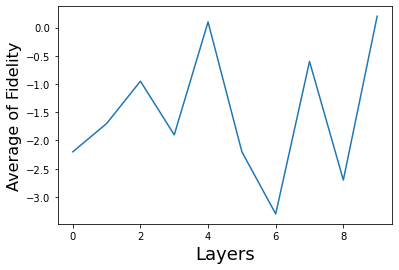

In [7]:
plt.plot(avg_std_fdlty_list)
plt.xlabel('Layers', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)

## RB stabilizer version (with Clifford set)

In [8]:
for m in tqdm(range(1,max_layer_num+1)):
    stabilizer_response = machine_response_stabilizer_bench(qmachine, n_qubit, m, k_m, n_m)
    avg_stab_fdlty_list.append( averageOfFidelity(stabilizer_response) )
np.save( os.path.join(path,'rb_stabilizer_{}_layers.npy'.format(max_layer_num)) ,np.array(avg_stab_fdlty_list))    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.36s/it]


Text(0, 0.5, 'Average of Fidelity')

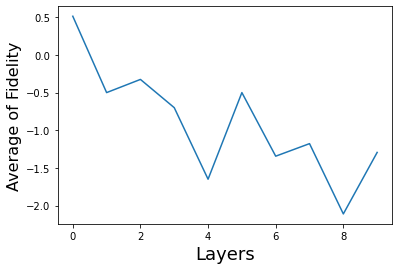

In [9]:
plt.plot(avg_stab_fdlty_list)
plt.xlabel('Layers', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)

## RB standard version (with Riggetti native gate set)

In [10]:
for m in tqdm(range(1,max_layer_num+1)):
    avg_rng_fdlty_list.append(averageOfFidelity(machine_response_srb_native_gate(qmachine, n_qubit, m, k_m, n_m)))

np.save( os.path.join(path,'rb_native_standard_{}_layers.npy'.format(max_layer_num)) ,np.array(avg_rng_fdlty_list))

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:21<00:05,  2.84s/it]

spotted


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:24<00:02,  2.74s/it]

spotted


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.71s/it]


Text(0, 0.5, 'Average of Fidelity')

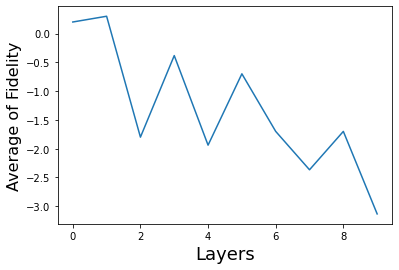

In [11]:
plt.plot(avg_rng_fdlty_list)
plt.xlabel('Layers', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)

## RB standard version (with arbitary random unitary set)

In [12]:
for m in tqdm(range(1,max_layer_num+1)):
    avg_runitary_fdlty_list.append(averageOfFidelity(machine_response_standard_bench_random_units(qmachine, n_qubit, m, k_m, n_m)))

np.save( os.path.join(path,'rb_random_unitary_standard_{}_layers.npy'.format(max_layer_num)) ,np.array(avg_runitary_fdlty_list))    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.65s/it]


Text(0, 0.5, 'Average of Fidelity')

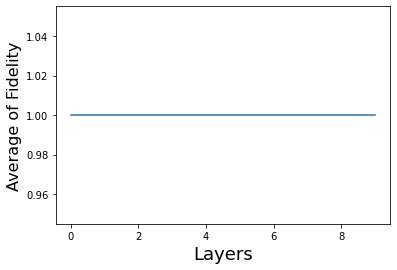

In [13]:
plt.plot(avg_runitary_fdlty_list)
plt.xlabel('Layers', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)